In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D

from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

In [2]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu'):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        #print(input_shape)
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False)
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False)
        
    def call(self, inputs):
        #self.mask_2 = tf.multiply(self.mask, self.mask_2)
        self.pruned_w = tf.multiply(self.w, self.mask)
        #print('layer inputy', inputs.shape)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()

        self.dense1 = CustomLayer(300)
        self.dense2 = CustomLayer(100)
        self.dense3 = CustomLayer(10, activation='softmax')
        
    def call(self, inputs):
        x = tf.keras.layers.Flatten()(inputs)
        #print('NN call',inputs.shape)
        x = self.dense1(x)
        
        x = self.dense2(x)
        #print(x.shape)
        return self.dense3(x)
    


In [3]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [6]:
model = LeNet300_100()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'],
              experimental_run_tf_function=False
             )
#model.run_eagerly= True
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(x=x_train,
          y=y_train,
          batch_size=64,
          epochs=5000,
          callbacks=[callback],
          validation_data=(x_test, y_test),
         )

Epoch 1/5000
938/938 [==============================] - 6s 7ms/step - loss: 1.5758 - accuracy: 0.8975 - val_loss: 1.5132 - val_accuracy: 0.9508
Epoch 2/5000
938/938 [==============================] - 6s 6ms/step - loss: 1.5097 - accuracy: 0.9544 - val_loss: 1.5050 - val_accuracy: 0.9589
Epoch 3/5000
938/938 [==============================] - 6s 6ms/step - loss: 1.4976 - accuracy: 0.9653 - val_loss: 1.4998 - val_accuracy: 0.9629
Epoch 4/5000
938/938 [==============================] - 6s 7ms/step - loss: 1.4912 - accuracy: 0.9714 - val_loss: 1.4932 - val_accuracy: 0.9690
Epoch 5/5000
938/938 [==============================] - 6s 7ms/step - loss: 1.4861 - accuracy: 0.9759 - val_loss: 1.4919 - val_accuracy: 0.9705
Epoch 6/5000
938/938 [==============================] - 6s 6ms/step - loss: 1.4826 - accuracy: 0.9793 - val_loss: 1.4889 - val_accuracy: 0.9726
Epoch 7/5000
938/938 [==============================] - 7s 7ms/step - loss: 1.4813 - accuracy: 0.9806 - val_loss: 1.4877 - val_accuracy:

In [7]:
model = LeNet300_100()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
              metrics=['accuracy'],
              experimental_run_tf_function=False
             )
model.fit(x=data.test,
          epochs=5,
          validation_data=(x_test, y_test),
         )

Epoch 1/5
79/79 [==============================] - 3s 37ms/step - loss: 1.8325 - accuracy: 0.6980 - val_loss: 1.6434 - val_accuracy: 0.8322
Epoch 2/5
79/79 [==============================] - 2s 28ms/step - loss: 1.5983 - accuracy: 0.8774 - val_loss: 1.5549 - val_accuracy: 0.9203
Epoch 3/5
79/79 [==============================] - 2s 28ms/step - loss: 1.5479 - accuracy: 0.9238 - val_loss: 1.5353 - val_accuracy: 0.9363
Epoch 4/5
79/79 [==============================] - 3s 42ms/step - loss: 1.5327 - accuracy: 0.9363 - val_loss: 1.5287 - val_accuracy: 0.9409
Epoch 5/5
79/79 [==============================] - 3s 34ms/step - loss: 1.5228 - accuracy: 0.9458 - val_loss: 1.5152 - val_accuracy: 0.9531


In [8]:
clean_inputs = []
x = data.test.take(1)


for z in tfds.as_numpy(x):
    for y in z[0]:
        clean_inputs.append(y.flatten())

clean_inputs = np.array(clean_inputs[:10])

In [9]:
clean_inputs


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
eps = .2
x = data.test.take(1)
x_fgm = projected_gradient_descent(model,clean_inputs, .15, .1, .1, 100, np.inf,0,1)
clean_preds = model(clean_inputs)
adv_preds = model(x_fgm)
for i in range(10):
    print(i,' clean: ', np.argmax(clean_preds[i]))
    print(i,' adversarial: ', np.argmax(adv_preds[i]))


ValueError: Norm order must be either np.inf or 2.

In [11]:
def projected_gradient_descent(model_fn, x, eps, eps_iter, nb_iter, norm,
                               clip_min=None, clip_max=None, y=None, targeted=False,
                               rand_init=None, rand_minmax=0.3, sanity_checks=True):
  """
  This class implements either the Basic Iterative Method
  (Kurakin et al. 2016) when rand_init is set to 0. or the
  Madry et al. (2017) method when rand_minmax is larger than 0.
  Paper link (Kurakin et al. 2016): https://arxiv.org/pdf/1607.02533.pdf
  Paper link (Madry et al. 2017): https://arxiv.org/pdf/1706.06083.pdf
  :param model_fn: a callable that takes an input tensor and returns the model logits.
  :param x: input tensor.
  :param eps: epsilon (input variation parameter); see https://arxiv.org/abs/1412.6572.
  :param eps_iter: step size for each attack iteration
  :param nb_iter: Number of attack iterations.

<tf.Tensor: shape=(784,), dtype=float32, numpy=
array([0.        , 0.        , 0.1       , 0.        , 0.        ,
       0.1       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.        ,
       0.        , 0.        , 0.        , 0.1       , 0.1       ,
       0.1       , 0.        , 0.1       , 0.1       , 0.        ,
       0.1       , 0.1       , 0.1       , 0.        , 0.        ,
       0.        , 0.        , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
       0.1       , 0.        , 0.        , 0.        , 0.1       ,
       0.        , 0.        , 0.1       , 0.        , 0.        ,
       0.1       , 0.        , 0.        , 0.        , 0.1       ,
       0.1       , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.1       , 0.        , 0.        , 0.        ,
       0.     

In [11]:
clean_inputs[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [23]:
def show_batch(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        img = tf.reshape(image_batch[n], (28,28))
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img)
        plt.title(np.argmax(label_batch[n]))
        plt.axis('off')
        

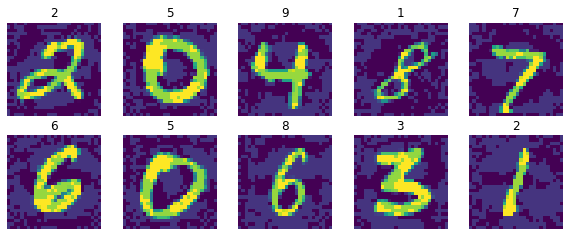

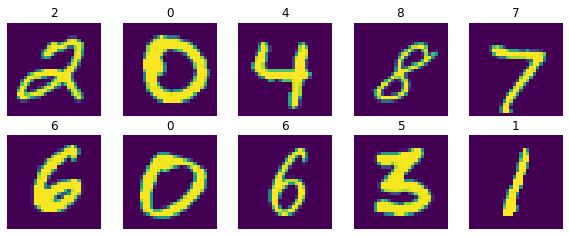

In [24]:
show_batch(x_fgm, adv_preds)
show_batch(clean_inputs,clean_preds)